## **House Prices Prediction : Data Cleaning and Feature Engineering**
---
Following the exploratory data analysis, this stage focuses on feature engineering and data preparation to construct informative and consistent input features for predictive modeling.

Data preparation is first performed to ensure data quality, including handling missing values and resolving features where missing entries represent the absence of certain property attributes rather than true missing data.

Feature engineering is then conducted to create new features and transform existing ones based on domain knowledge and insights derived from exploratory analysis.

In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [ ]:
# Load data
train = pd.read_csv('train.csv', keep_default_na=False, na_values=[''])
test = pd.read_csv('test.csv', keep_default_na=False, na_values=[''])

# Split features and target
y_train = train['SalePrice'].copy()
test_ids = test['Id'].copy()

# Add indicator columns for train/test sets
train['is_train'] = 1
test['is_train'] = 0

# Add target column to test (as NaN)
test['SalePrice'] = np.nan

# Concatenate train and test data
all_data = pd.concat([train, test], ignore_index=True)

print(f"Combined data shape: {all_data.shape}")
all_data.head()

Combined data shape: (2919, 82)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,is_train
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,NA,NA,NA,0,2,2008,WD,Normal,208500.0,1
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,NA,NA,NA,0,5,2007,WD,Normal,181500.0,1
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,NA,0,9,2008,WD,Normal,223500.0,1
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,NA,0,2,2006,WD,Abnorml,140000.0,1
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,NA,0,12,2008,WD,Normal,250000.0,1


Based on the dataset description, several features contain NA values that do not indicate missing data, but rather the absence of a particular property feature. These include attributes related to basements, garages, pools, and other facilities, such as:

`Alley`, `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`,
`BsmtFinType2`, `FireplaceQu`, `GarageType`, `GarageFinish`,
`GarageQual`, `GarageCond`, `PoolQC`, `Fence`, and `MiscFeature`.

For these features, NA values are treated as a valid category indicating that the corresponding feature does not exist for a given property.

In [19]:
# Handle missing values
VALID_NA_COLS = [
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
    'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
    'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'
]

# Replace 'NA' with 'None' for valid NA columns
for col in VALID_NA_COLS:
    all_data[col] = all_data[col].fillna('None')

To assess the completeness of the dataset, missing values are examined using both the absolute count and the percentage of missing entries. The `missing_pct` metric represents the proportion of missing values in each feature relative to the total number of observations.

In [20]:
missing_df = pd.DataFrame({
    'missing_count': all_data.isnull().sum(),
    'missing_pct': all_data.isnull().mean() * 100
}).query('missing_count > 0').sort_values('missing_count', ascending=False)

missing_df

,missing_count,missing_pct
SalePrice,1459,49.982871


The results indicate that the only remaining missing values are found in the target variable (`SalePrice`). These missing entries correspond exclusively to the test dataset, where the target values are intentionally unavailable and will be predicted by the model.

All feature columns have been successfully processed, and no missing values remain in the input features, confirming that the preprocessing step has been completed correctly. Consequently, the next step is to perform feature engineering to extract additional information and improve model performance.

### **Feature Engineering**

In [23]:
# Age-related features
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['RemodAge'] = all_data['YrSold'] - all_data['YearRemodAdd']
all_data['IsRemodeled'] = (all_data['YearBuilt'] != all_data['YearRemodAdd']).astype(int)

In [25]:
# Total living area
num_cols = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']

for col in num_cols:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce')

all_data[num_cols] = all_data[num_cols].fillna(0)

all_data['TotalLivingArea'] = (
    all_data['TotalBsmtSF']
    + all_data['1stFlrSF']
    + all_data['2ndFlrSF']
)

In [27]:
# Basement features
bsmt_area_cols = [
    'BsmtFinSF1',
    'BsmtFinSF2',
    'TotalBsmtSF'
]

for col in bsmt_area_cols:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce')

all_data[bsmt_area_cols] = all_data[bsmt_area_cols].fillna(0)

bsmt_fin_map = {
    'NA': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
}

all_data['BsmtFinType1_ord'] = all_data['BsmtFinType1'].map(bsmt_fin_map)
all_data['BsmtFinType2_ord'] = all_data['BsmtFinType2'].map(bsmt_fin_map)

all_data['FinishedBsmtSF'] = (
    all_data['BsmtFinSF1'] + all_data['BsmtFinSF2']
)

all_data['FinishedBsmtRatio'] = (
    all_data['FinishedBsmtSF'] / (all_data['TotalBsmtSF'] + 1)
)

In [36]:
# Total bathrooms (weighted)
bath_cols = [
    'FullBath', 'HalfBath',
    'BsmtFullBath', 'BsmtHalfBath'
]

for col in bath_cols:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce')

all_data[bath_cols] = all_data[bath_cols].fillna(0)

all_data['TotalBath'] = (
    all_data['FullBath']
    + 0.5 * all_data['HalfBath']
    + all_data['BsmtFullBath']
    + 0.5 * all_data['BsmtHalfBath']
)

# Room density (proxy for spaciousness)
all_data['RoomDensity'] = (
    all_data['GrLivArea'] / (all_data['TotRmsAbvGrd'] + 1)
)

/var/folders/6j/dgt8rbb15g52cv5l608mbm2c0000gn/T/ipykernel_29190/1669459852.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['TotalBath'] = (
/var/folders/6j/dgt8rbb15g52cv5l608mbm2c0000gn/T/ipykernel_29190/1669459852.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['RoomDensity'] = (


In [29]:
# Overall quality and condition interaction
all_data['OverallQC'] = (
    all_data['OverallQual'] * all_data['OverallCond']
)

all_data['QualCondGap'] = (
    all_data['OverallQual'] - all_data['OverallCond']
)

In [30]:
# Porch and deck features
all_data['TotalPorchSF'] = (
    all_data['OpenPorchSF']
    + all_data['EnclosedPorch']
    + all_data['3SsnPorch']
    + all_data['ScreenPorch']
)

all_data['HasPorch'] = (all_data['TotalPorchSF'] > 0).astype(int)
all_data['HasDeck'] = (all_data['WoodDeckSF'] > 0).astype(int)

In [40]:
# Garage features
garage_num_cols = ['GarageArea', 'GarageYrBlt', 'GarageCars']

for col in garage_num_cols:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce')

all_data[['GarageArea', 'GarageCars']] = all_data[['GarageArea', 'GarageCars']].fillna(0)

all_data['HasGarage'] = (all_data['GarageArea'] > 0).astype(int)

all_data['GarageAge'] = (
    all_data['YrSold'] - all_data['GarageYrBlt']
).where(all_data['GarageYrBlt'] > 0, 0)

all_data['GarageAreaPerCar'] = (
    all_data['GarageArea'] / (all_data['GarageCars'] + 1)
)

garage_qual_map = {
    'None': 0,
    'Po': 1,
    'Fa': 2,
    'TA': 3,
    'Gd': 4,
    'Ex': 5
}

all_data['GarageQual_ord'] = all_data['GarageQual'].map(garage_qual_map)
all_data['GarageCond_ord'] = all_data['GarageCond'].map(garage_qual_map)

all_data['GarageQC'] = (
    all_data['GarageQual_ord'] * all_data['GarageCond_ord']
)


/var/folders/6j/dgt8rbb15g52cv5l608mbm2c0000gn/T/ipykernel_29190/2427227409.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['GarageQual_ord'] = all_data['GarageQual'].map(garage_qual_map)
/var/folders/6j/dgt8rbb15g52cv5l608mbm2c0000gn/T/ipykernel_29190/2427227409.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['GarageCond_ord'] = all_data['GarageCond'].map(garage_qual_map)
/var/folders/6j/dgt8rbb15g52cv5l608mbm2c0000gn/T/ipykernel_29190/2427227409.py:31: PerformanceWarning: DataFrame is highly fragmen

In [41]:
# Masonry veneer features
all_data['MasVnrArea'] = pd.to_numeric(all_data['MasVnrArea'], errors='coerce').fillna(0)

all_data['HasMasVnr'] = (all_data['MasVnrArea'] > 0).astype(int)

/var/folders/6j/dgt8rbb15g52cv5l608mbm2c0000gn/T/ipykernel_29190/3047107000.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['HasMasVnr'] = (all_data['MasVnrArea'] > 0).astype(int)


In [33]:
# Pool and fireplace features
all_data['HasPool'] = (all_data['PoolArea'] > 0).astype(int)
all_data['HasFireplace'] = (all_data['Fireplaces'] > 0).astype(int)

In [42]:
# Lot and access features
all_data['LotFrontage'] = pd.to_numeric(all_data['LotFrontage'], errors='coerce')

all_data['LotFrontage'] = (
    all_data.groupby('Neighborhood')['LotFrontage']
    .transform(lambda x: x.fillna(x.median()))
)

all_data['LotArea'] = pd.to_numeric(all_data['LotArea'], errors='coerce')


all_data['HasAlley'] = (all_data['Alley'] != 'None').astype(int)
all_data['IsPavedStreet'] = (all_data['Street'] == 'Pave').astype(int)

all_data['LotShapeRatio'] = (
    all_data['LotFrontage'] / (np.sqrt(all_data['LotArea']) + 1)
)

/var/folders/6j/dgt8rbb15g52cv5l608mbm2c0000gn/T/ipykernel_29190/2584925371.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data['LotShapeRatio'] = (


In [35]:
# Season from month sold
all_data['SaleSeason'] = all_data['MoSold'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})


In [43]:
# Final copy of all_data
all_data = all_data.copy()

In [46]:
train_fe = all_data[all_data['is_train'] == 1].copy()
train_fe['LogSalePrice'] = np.log1p(train_fe['SalePrice'])


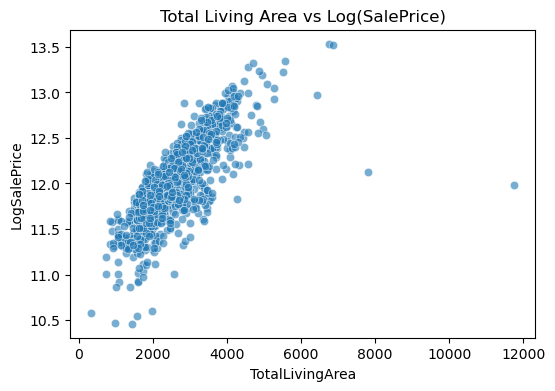

In [47]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    x='TotalLivingArea',
    y='LogSalePrice',
    data=train_fe,
    alpha=0.6
)
plt.title('Total Living Area vs Log(SalePrice)')
plt.show()

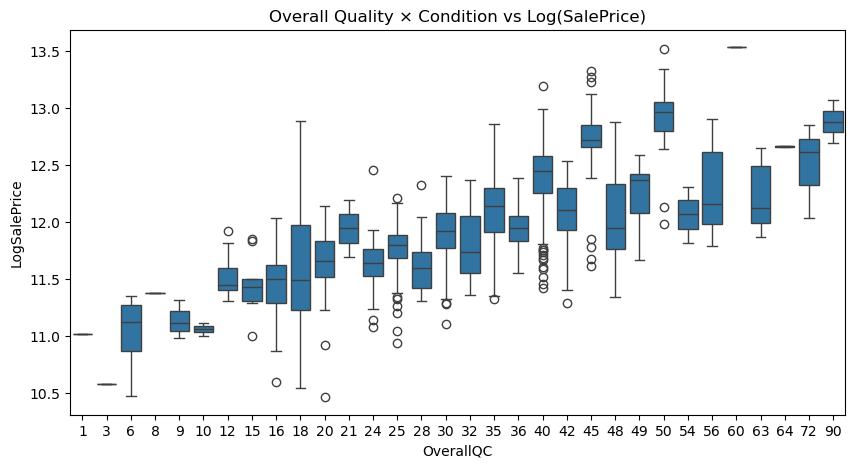

In [50]:
plt.figure(figsize=(10,5))
sns.boxplot(
    x='OverallQC',
    y='LogSalePrice',
    data=train_fe
)
plt.title('Overall Quality × Condition vs Log(SalePrice)')
plt.show()

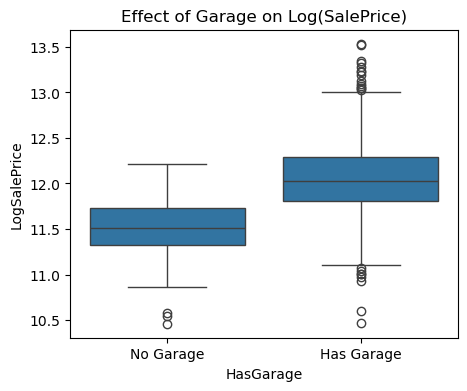

In [51]:
plt.figure(figsize=(5,4))
sns.boxplot(
    x='HasGarage',
    y='LogSalePrice',
    data=train_fe
)
plt.xticks([0,1], ['No Garage', 'Has Garage'])
plt.title('Effect of Garage on Log(SalePrice)')
plt.show()

In [61]:
# Save processed data
train_fe = all_data[all_data['is_train'] == 1].copy()
test_fe  = all_data[all_data['is_train'] == 0].copy()

train_fe.drop(columns=['is_train'], inplace=True)
test_fe.drop(columns=['is_train', 'SalePrice'], inplace=True)

train_fe.to_csv('train_fe.csv', index=False)
test_fe.to_csv('test_fe.csv', index=False)


In [63]:
train_fe.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,TotalBath,RoomDensity,HasGarage,GarageAge,GarageAreaPerCar,GarageQual_ord,GarageCond_ord,GarageQC,HasMasVnr,LotShapeRatio
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,3.5,190.000000,1,5.0,182.666667,3,3,9,1,0.699497
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,2.5,180.285714,1,31.0,153.333333,3,3,9,0,0.808247
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,3.5,255.142857,1,7.0,202.666667,3,3,9,1,0.635122
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,2.0,214.625000,1,8.0,160.500000,3,3,9,0,0.607754
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,3.5,219.800000,1,8.0,209.000000,3,3,9,1,0.697586


In [64]:
test_fe.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,TotalBath,RoomDensity,HasGarage,GarageAge,GarageAreaPerCar,GarageQual_ord,GarageCond_ord,GarageQC,HasMasVnr,LotShapeRatio
1460,1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,...,1.0,149.333333,1,49.0,365.000000,3,3,9,0,0.735258
1461,1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,...,1.5,189.857143,1,52.0,156.000000,3,3,9,1,0.672509
1462,1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,...,2.5,232.714286,1,13.0,160.666667,3,3,9,0,0.623941
1463,1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,...,2.5,200.500000,1,12.0,156.666667,3,3,9,1,0.773120
1464,1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,...,2.0,213.333333,1,18.0,168.666667,3,3,9,0,0.599336
